In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /home/gd1279/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [5]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import defaultdict, deque
import os
import argparse
import atari_py
import torch

from agent import Agent
from env import make_env
from masker import ALL_MASKERS

In [6]:
np.set_printoptions(precision=5)

In [7]:
api = wandb.Api()

In [8]:
CHECKPOINT_SCRATCH_FOLDER = '/scratch/gd1279'

if not os.path.exists(CHECKPOINT_SCRATCH_FOLDER):
    os.mkdir(CHECKPOINT_SCRATCH_FOLDER)

# Recreate the args 

In [9]:
# Note that hyperparameters may originally be reported in ATARI game frames instead of agent steps
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')
parser.add_argument('--save-evaluation-gifs', action='store_true', help='Save GIFs of evaluation episodes')
parser.add_argument('--evaluation-gif-folder', default=None, help='Folder to save evaluation GIFs in')
parser.add_argument('--save-evaluation-states', action='store_true', help='Save the states of evaluation episodes')
parser.add_argument('--evaluation-state-folder', default=None, help='Folder to save evaluation state in')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)
parser.add_argument('--memory-save-interval', type=int, default=None, help='How often to save the memory, defaults to the evaluation interval')
parser.add_argument('--use-native-pickle-serialization', action='store_true', help='Use native pickle saving rather than torch.save()')

# Arguments for the augmented representations
parser.add_argument('--add-masks', action='store_true', help='Add masks for each semantic object types')
parser.add_argument('--maskers', default=None, help='Select specific maskers to use')
parser.add_argument('--use-numpy-masker', action='store_true', help='Use the previous, much slower numpy-based masker')
parser.add_argument('--omit-pixels', action='store_true', help='Omit the raw pixels from the environment')

# Arguments to give it a soft time cap that will help it not fail
parser.add_argument('--soft-time-cap', help='Format: <DD>:HH:MM, stop after some soft cap such that the saving the memory does not fail')

# Debugging-related arguments
parser.add_argument('--debug-heap', action='store_true')
parser.add_argument('--heap-interval', default=1e4)
parser.add_argument('--heap-debug-file', default=None)


_StoreAction(option_strings=['--heap-debug-file'], dest='heap_debug_file', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

# Load a run and its model

In [10]:
def download_checkpoint(run, step=None):
    files = run.files()
    if step is None:
        step = max([int(f.name[f.name.rfind('-') + 1:f.name.rfind('.')]) 
                    for f in files 
                    if f.name.endswith('.pth')])
        
    sample_name = [f.name for f in files if f.name.endswith('.pth')][0]
    checkpoint_name = sample_name[:sample_name.rfind('-')]
    checkpoint_file = f'{checkpoint_name}-{step}.pth'
    run.file(checkpoint_file).download(replace=True, root=CHECKPOINT_SCRATCH_FOLDER)
    return os.path.join(CHECKPOINT_SCRATCH_FOLDER, checkpoint_file)


def setup_args(run):
    args = parser.parse_args([])
    config = run.config
    
    for key in config:
        if key in args:
            args.__setattr__(key, config[key])
            
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    if torch.cuda.is_available() and not args.disable_cuda:
        args.device = torch.device('cuda')
        # torch.cuda.manual_seed(np.random.randint(1, 10000))
        torch.cuda.manual_seed(args.seed)
        torch.backends.cudnn.enabled = args.enable_cudnn
    else:
        args.device = torch.device('cpu')
            
    return args


LOADED_MODEL_CACHE = {}


def load_model_from_run(run, cache=LOADED_MODEL_CACHE):
    if run not in cache:
        checkpoint_path = download_checkpoint(run)
        args = setup_args(run)
        args.model = checkpoint_path

        env = make_env(args)
        dqn = Agent(args, env)
        cache[run] = dqn, env
        
    return cache[run]

# Gameplan

1. Load the saved full-res/color states.
2. Pass them through the baseline model and create/plot t-SNE embeddings.
3. Color them by their value (according to the baseline model)

This essentially recreates the analysis in the Nature DQN paper.

4. Augment the states and pass them through an augmented model.
5. Color by the value differences between models. If the distribution is vastly different, consider normalizing.
6. Repeat this exercise for baseline and masks+pixels, baseline and masks, and masks+pixels and masks.
7. Show sample states/images from different clusters

Questions:

* Do I want to use every single state? Or maybe skip and use every other or something?

## Utilities

In [11]:
from MulticoreTSNE import MulticoreTSNE as TSNE


def rgb_to_grayscale(obs):
    # My best approximation of how the ALE does it
    rgb = obs.astype('float32')
    return (rgb[:,:,0] * 0.299 + rgb[:,:,1] * 0.587 + rgb[:,:,2] * 0.114).astype(np.uint8)


def observation_to_model(env, obs):
    return env._prepare_state(env._to_tensor(rgb_to_grayscale(obs)), env._to_tensor(obs))


MAX_STATE_IDX = None
SKIP = 2


def pass_states_through_model(model, env, observations, max_state_idx=MAX_STATE_IDX, skip=SKIP):
    state_buffer = deque([], maxlen=4)
    hidden_states = []
    state_values = []
    actions = []

    for frame in observations[:3]:
        state_buffer.append(observation_to_model(env, frame))

    with torch.no_grad():
        for frame in observations[3:max_state_idx]:
            state_buffer.append(observation_to_model(env, frame))
            state = torch.cat(list(state_buffer), 0)
            
            hidden_state = model.online_net.convs(state.unsqueeze(0)).view(-1)
            hidden_states.append(hidden_state.detach().cpu().numpy())
            
            state_values.append(model.evaluate_q(state))
            actions.append(model.act(state))

    hidden_state_array = np.array(hidden_states[::skip])
    state_value_array = np.array(state_values[::skip])
    action_array = np.array(actions[::skip])
    
    return hidden_state_array, state_value_array, action_array


def plot_entire_state(observations, start_index, num_frames=4):
    figure = plt.figure(figsize=(18, 4))
    for i in range(num_frames):
        ax = plt.subplot(1, num_frames, i + 1)
        ax.imshow(observations[start_index + i])
        
    plt.show()
    
    
ALE_ACTIONS = {
    0: 'noop',
    1: 'fire',
    2: 'up',
    3: 'right',
    4: 'left',
    5: 'down',
    6: 'up + right',
    7: 'up + left',
    8: 'down + right',
    9: 'down + left',
    10: 'up + fire',
    11: 'right + fire',
    12: 'left + fire',
    13: 'down + fire',
    14: 'up + right + fire',
    15: 'up + left + fire',
    16: 'down + right + fire',
    17: 'down + left + fire'
}

## 1

In [12]:
SAMPLE_SAVED_STATES = r'/home/gd1279/scratch/rainbow-evaluation-state-traces/baseline-rainbow-305/evaluation/states/eval-baseline-rainbow-305-34350000-0-env.pickle'

with open(SAMPLE_SAVED_STATES, 'rb') as state_file:
    sample_full_color_observations = pickle.load(state_file)
    
    
sample_full_color_observations = sample_full_color_observations.astype(np.uint8)
print(sample_full_color_observations.shape)

(5671, 210, 160, 3)


## 2

Using model 306 from the baseline condition, one of the average models, not the 'superstar' one

In [13]:
baseline_run = api.run('augmented-frostbite/initial-experiments/runs/fdxobftk')
baseline_model, baseline_env = load_model_from_run(baseline_run)

Loading pretrained model: /scratch/gd1279/baseline-rainbow-306-29150000.pth


In [14]:
baseline_hidden_state_array, baseline_state_value_array, baseline_action_array = \
    pass_states_through_model(baseline_model, baseline_env, sample_full_color_observations, skip=1)

baseline_hidden_state_array.shape

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(5668, 3136)

In [15]:
tsne = TSNE(n_jobs=4)
Y = tsne.fit_transform(baseline_hidden_state_array)
Y.shape

(5668, 2)

## 3

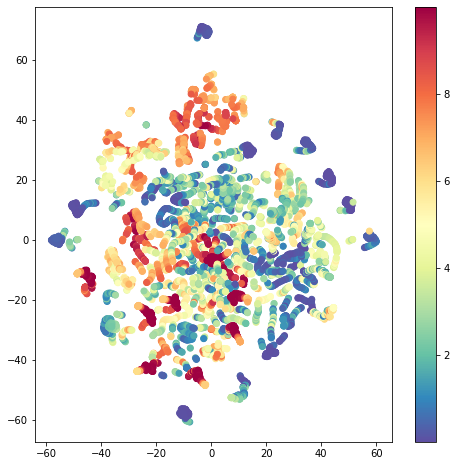

In [17]:
plt.figure(figsize=(8, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')
plt.scatter(Y[:, 0], Y[:, 1], c=baseline_state_value_array, cmap=cmap)
plt.colorbar()

(array([1213.,  503.,  502.,  506.,  492.,  438.,  542.,  553.,  351.,
         568.]),
 array([7.10739e-03, 1.00640e+00, 2.00569e+00, 3.00497e+00, 4.00426e+00,
        5.00355e+00, 6.00284e+00, 7.00213e+00, 8.00142e+00, 9.00071e+00,
        1.00000e+01]),
 <a list of 10 Patch objects>)

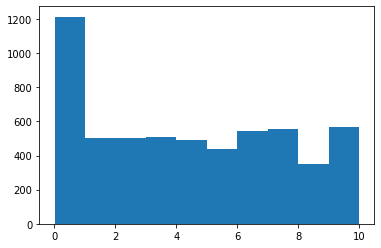

In [18]:
plt.hist(baseline_state_value_array)

## 4

In [19]:
masks_and_pixels_run = api.run('augmented-frostbite/masks-and-pixels-replication/runs/grh1bzvv')
masks_and_pixels_model, masks_and_pixels_env = load_model_from_run(masks_and_pixels_run)

Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-306-10000000.pth


In [21]:
_, masks_and_pixels_state_value_array, masks_and_pixels_action_array = \
    pass_states_through_model(masks_and_pixels_model, masks_and_pixels_env, sample_full_color_observations, skip=1)

(array([1502.,  446.,  311.,  256.,  261.,  347.,  572.,  769.,  379.,
         825.]),
 array([1.84557e-03, 1.00166e+00, 2.00147e+00, 3.00129e+00, 4.00110e+00,
        5.00092e+00, 6.00073e+00, 7.00055e+00, 8.00036e+00, 9.00018e+00,
        9.99999e+00]),
 <a list of 10 Patch objects>)

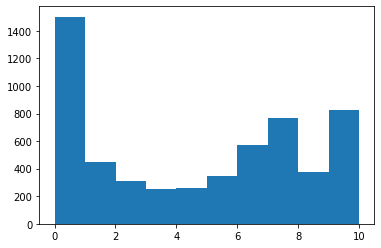

In [22]:
plt.hist(masks_and_pixels_state_value_array)

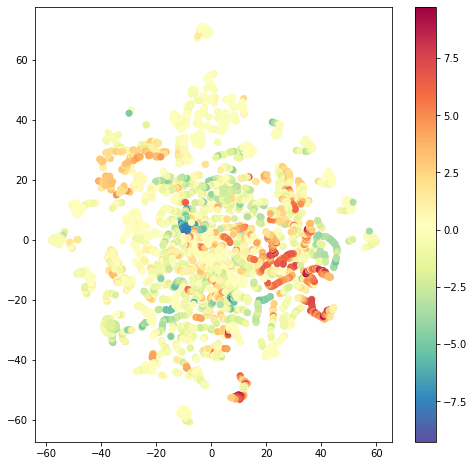

In [24]:
plt.figure(figsize=(8, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')
plt.scatter(Y[:, 0], Y[:, 1], c=masks_and_pixels_state_value_array - baseline_state_value_array, cmap=cmap)
plt.colorbar()

-3.99759317003781 3.949906651548266


(array([  15.,   53.,  153.,  580., 2885.,  978.,  560.,  271.,  134.,
          39.]),
 array([-3.99759, -3.20284, -2.40809, -1.61334, -0.81859, -0.02384,
         0.77091,  1.56566,  2.36041,  3.15516,  3.94991]),
 <a list of 10 Patch objects>)

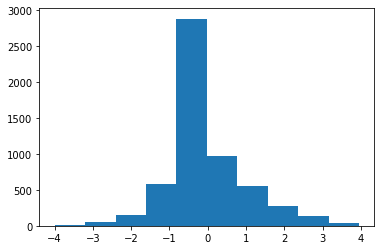

In [25]:
state_value_diffs = masks_and_pixels_state_value_array - baseline_state_value_array
normalized_diffs = (state_value_diffs - np.mean(state_value_diffs)) / np.std(state_value_diffs)

print(np.min(normalized_diffs), np.max(normalized_diffs))
plt.hist(normalized_diffs)

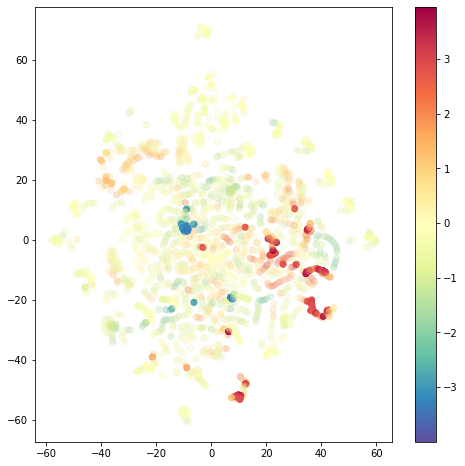

In [34]:
plt.figure(figsize=(8, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')
normalizer = matplotlib.colors.Normalize(np.min(normalized_diffs), np.max(normalized_diffs))

colors = np.array([cmap(normalizer(d)) for d in normalized_diffs])
colors[:,3] = np.abs(normalized_diffs) / np.max(np.abs(normalized_diffs))
colors[colors[:,3] > 0.7, 3] = 1
colors[colors[:,3] < 0.7, 3] = 0.1

pc = plt.scatter(Y[:, 0], Y[:, 1], color=colors)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca())

In [27]:
sum(normalized_diffs > 3.5), sum(normalized_diffs < -3.5)
print(np.nonzero(normalized_diffs > 3.5))
print(np.nonzero(normalized_diffs < -3.5))

(array([ 198,  199, 1662, 1674, 1979, 1996, 2289, 2292, 2296, 2658, 2659,
       2662, 2685, 5133]),)
(array([474, 481]),)


At index 1665, masks+pixels had value 9.967 => down + right + fire (16), pixels only had value 2.168 => up + right (6)


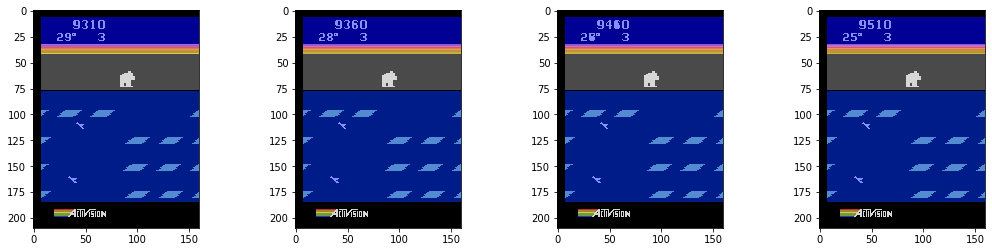

At index 1668, masks+pixels had value 9.929 => down + right + fire (16), pixels only had value 2.239 => up + right (6)


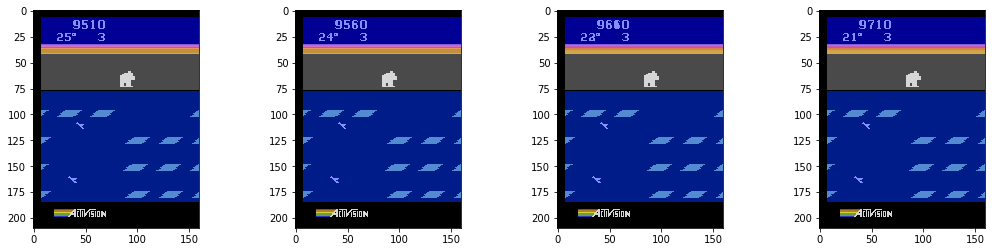

At index 1677, masks+pixels had value 9.711 => down + right + fire (16), pixels only had value 2.077 => up + right (6)


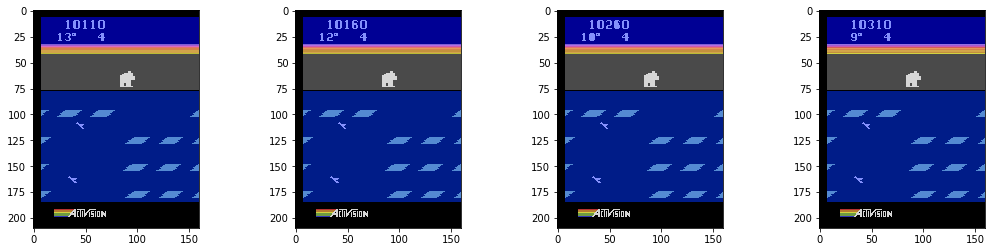

At index 1960, masks+pixels had value 7.672 => down + right + fire (16), pixels only had value 0.056 => noop (0)


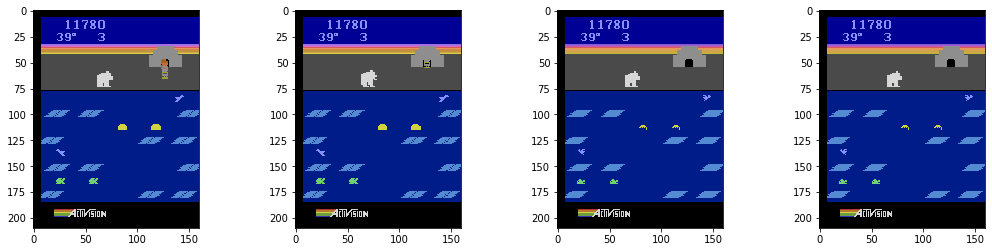

At index 2019, masks+pixels had value 9.990 => down + right + fire (16), pixels only had value 1.500 => down (5)


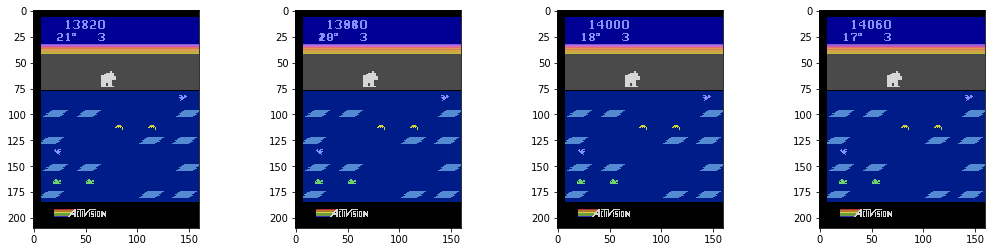

At index 2261, masks+pixels had value 8.176 => up + right + fire (14), pixels only had value 0.233 => up + right (6)


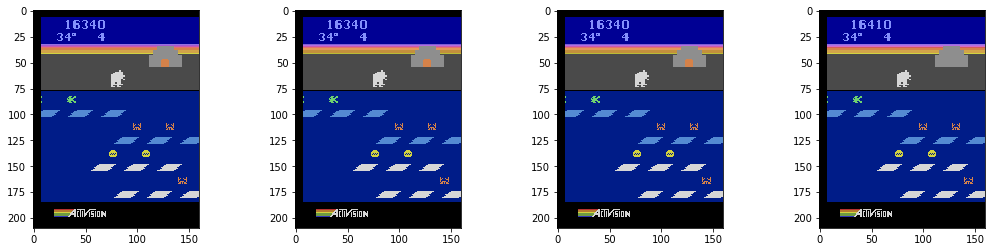

At index 2262, masks+pixels had value 8.100 => up + right + fire (14), pixels only had value 0.135 => up + right (6)


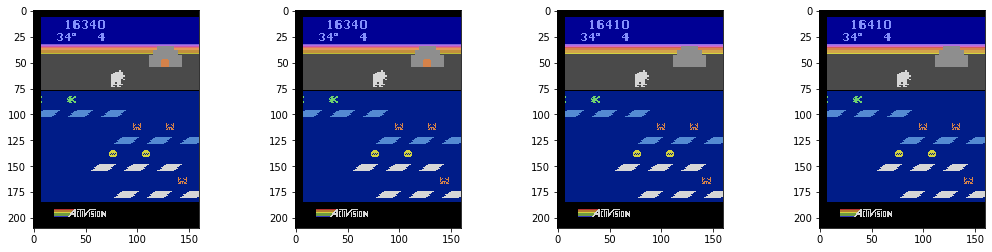

At index 2288, masks+pixels had value 9.733 => down + right + fire (16), pixels only had value 1.543 => up + right (6)


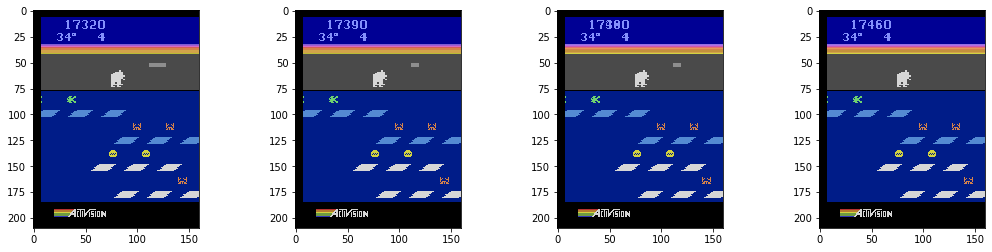

At index 2290, masks+pixels had value 9.899 => down + right + fire (16), pixels only had value 1.837 => up + right (6)


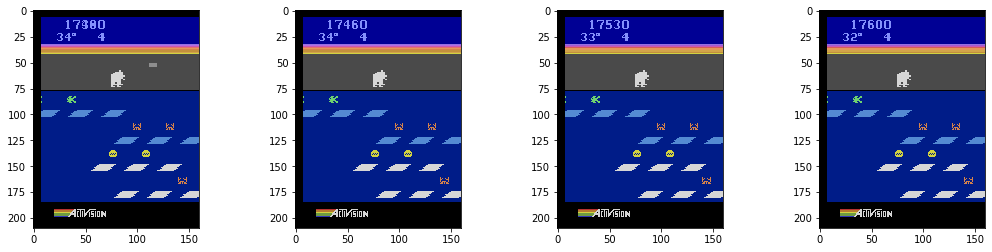

At index 2293, masks+pixels had value 9.951 => down + right + fire (16), pixels only had value 1.929 => up + right (6)


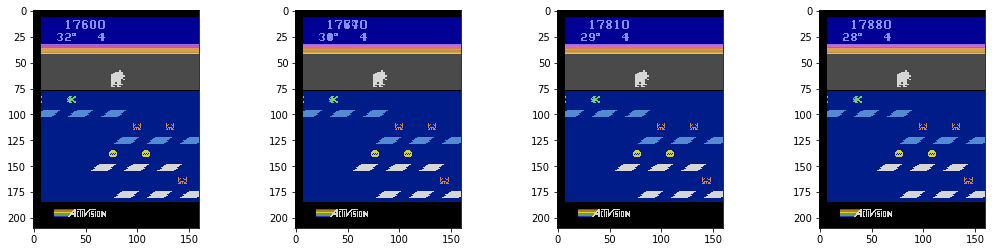

At index 2295, masks+pixels had value 9.964 => down + right + fire (16), pixels only had value 2.226 => up + right (6)


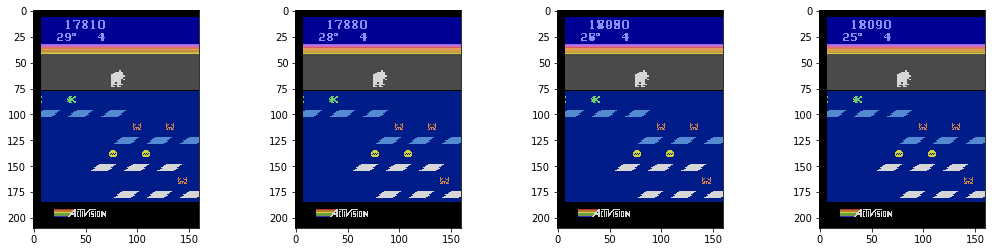

At index 2297, masks+pixels had value 9.949 => down + right + fire (16), pixels only had value 2.178 => up + right (6)


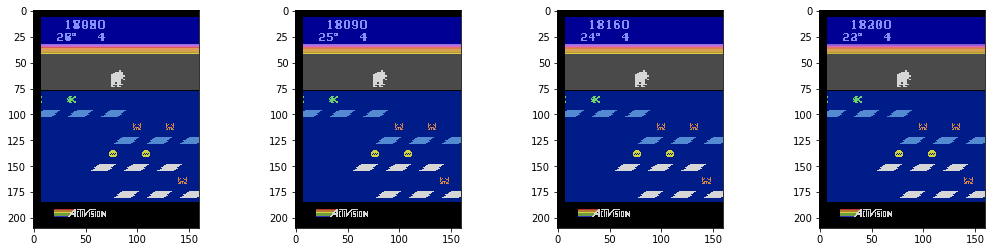

At index 2298, masks+pixels had value 9.911 => down + right + fire (16), pixels only had value 1.750 => up + right (6)


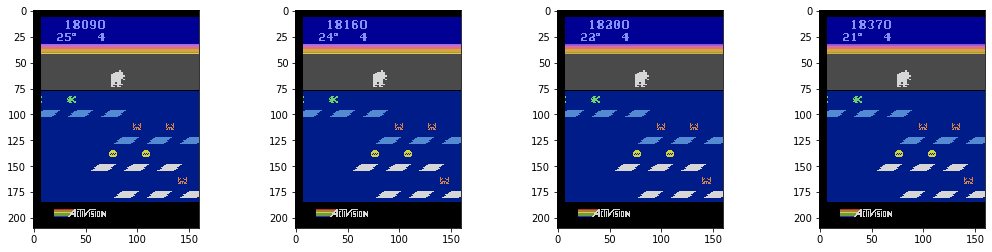

At index 2299, masks+pixels had value 9.863 => down + right + fire (16), pixels only had value 1.341 => up + right (6)


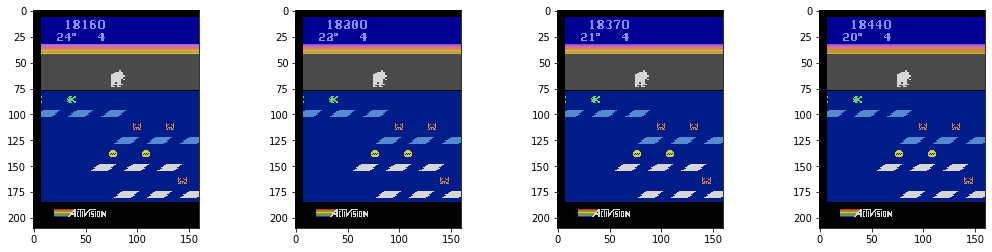

At index 2301, masks+pixels had value 9.942 => down + right + fire (16), pixels only had value 2.292 => up + right (6)


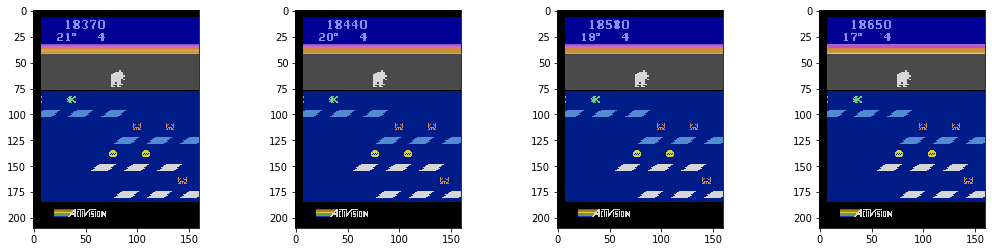

At index 2302, masks+pixels had value 9.806 => down + right + fire (16), pixels only had value 1.782 => up + right (6)


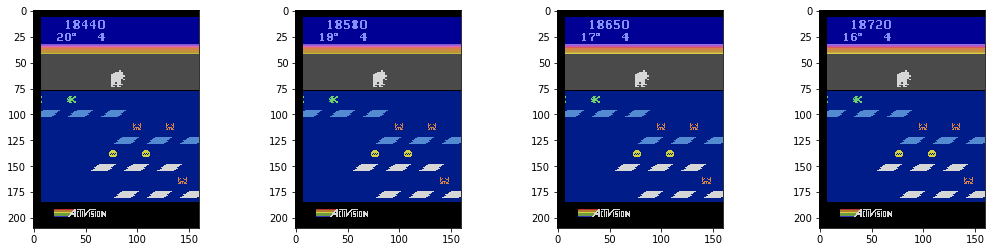

At index 2304, masks+pixels had value 9.818 => down + right + fire (16), pixels only had value 1.570 => up + right (6)


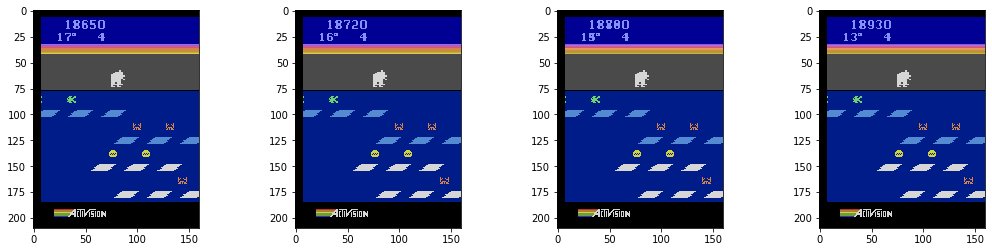

At index 2305, masks+pixels had value 9.705 => down + right + fire (16), pixels only had value 1.705 => up + right (6)


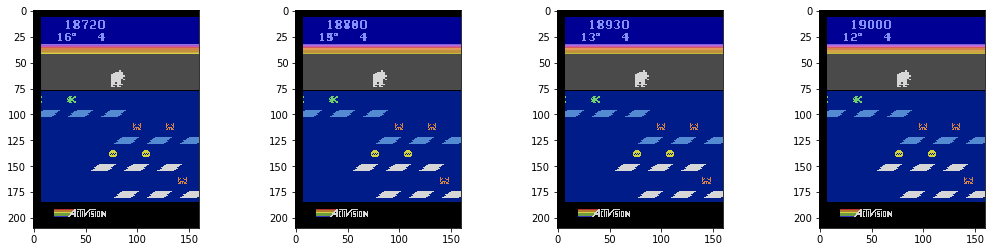

At index 2307, masks+pixels had value 9.530 => down + right + fire (16), pixels only had value 1.147 => up + right (6)


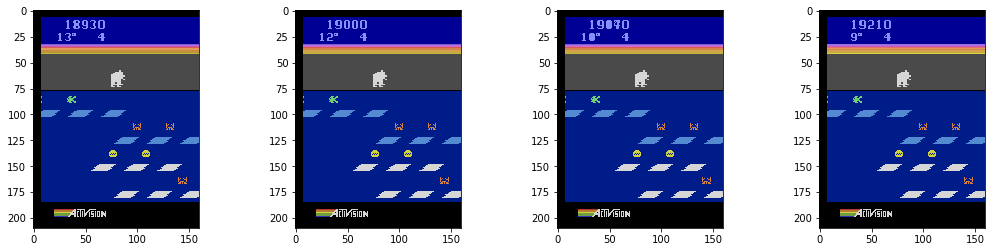

At index 2660, masks+pixels had value 9.601 => up + right + fire (14), pixels only had value 1.756 => noop (0)


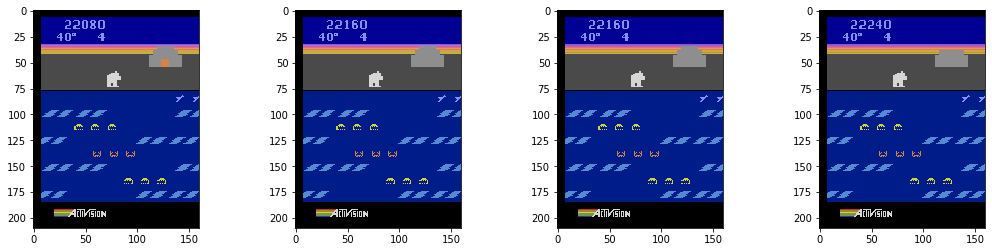

At index 2666, masks+pixels had value 9.169 => up + right + fire (14), pixels only had value 1.079 => up + left + fire (15)


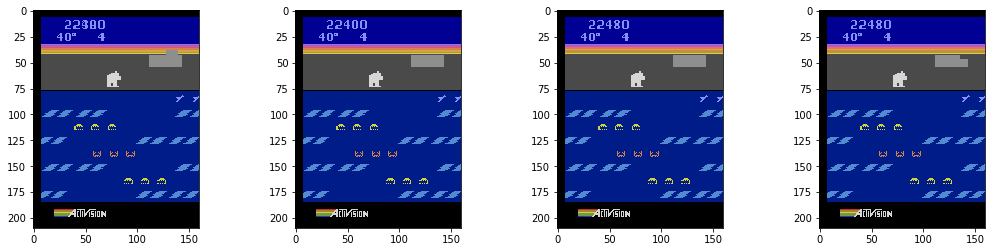

At index 2687, masks+pixels had value 9.980 => down + right + fire (16), pixels only had value 2.034 => up + right (6)


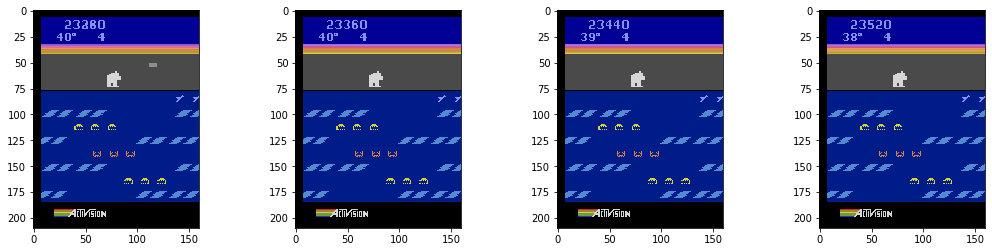

At index 2689, masks+pixels had value 9.994 => down + right + fire (16), pixels only had value 1.591 => up + right (6)


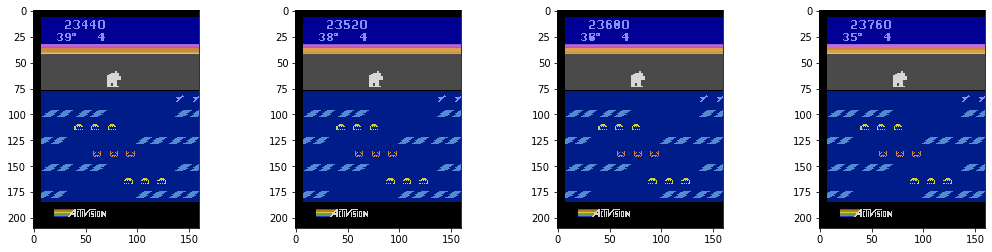

At index 2693, masks+pixels had value 9.962 => down + right + fire (16), pixels only had value 1.578 => up + right (6)


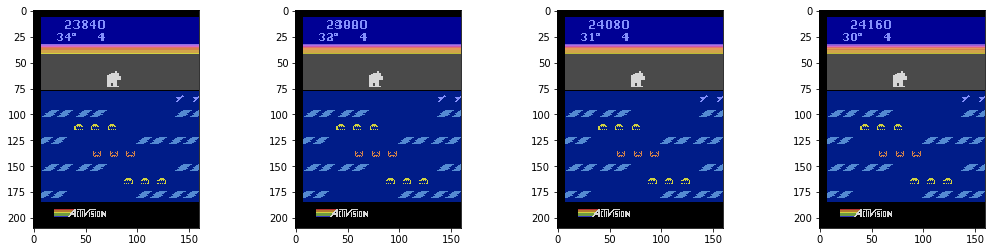

At index 2695, masks+pixels had value 9.974 => down + right + fire (16), pixels only had value 2.414 => up + right (6)


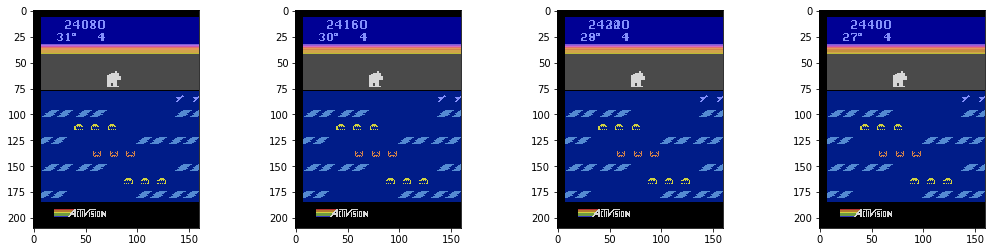

At index 2696, masks+pixels had value 9.984 => down + right + fire (16), pixels only had value 1.820 => up + right (6)


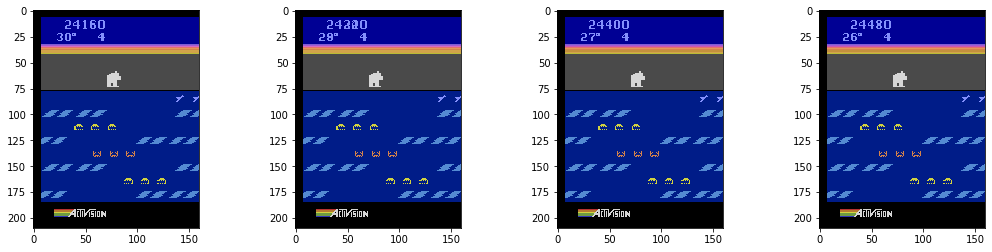

At index 2698, masks+pixels had value 9.975 => down + right + fire (16), pixels only had value 1.845 => up + right (6)


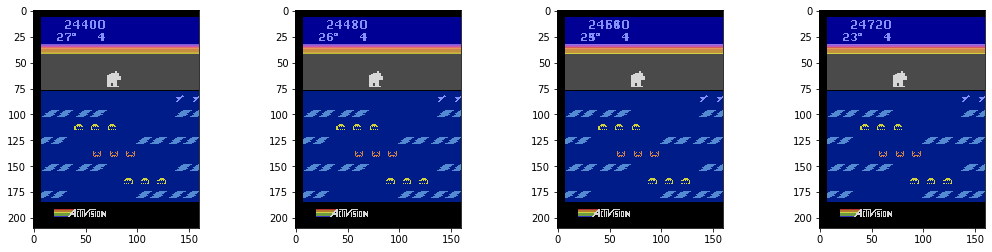

At index 2699, masks+pixels had value 9.973 => down + right + fire (16), pixels only had value 2.145 => up + right (6)


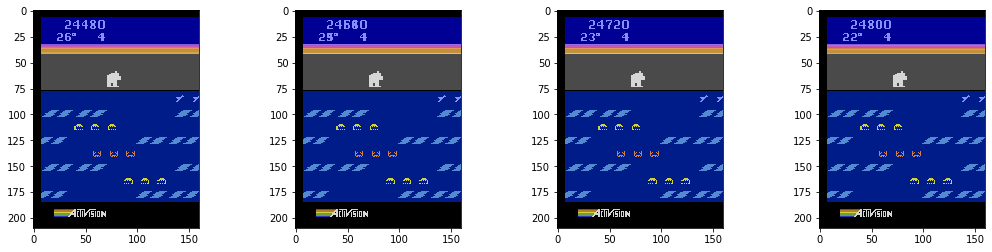

At index 2704, masks+pixels had value 9.962 => down + right + fire (16), pixels only had value 2.388 => up + right (6)


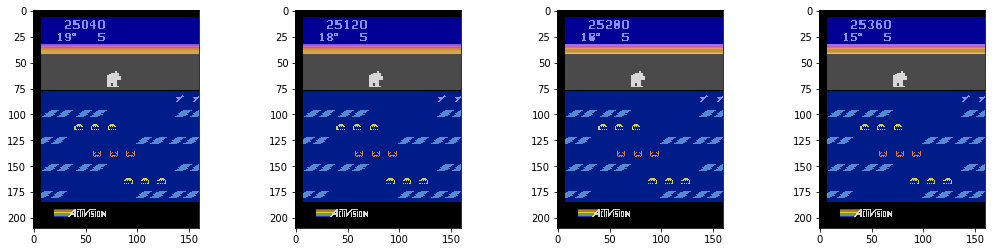

At index 2705, masks+pixels had value 9.912 => down + right + fire (16), pixels only had value 1.499 => up + right (6)


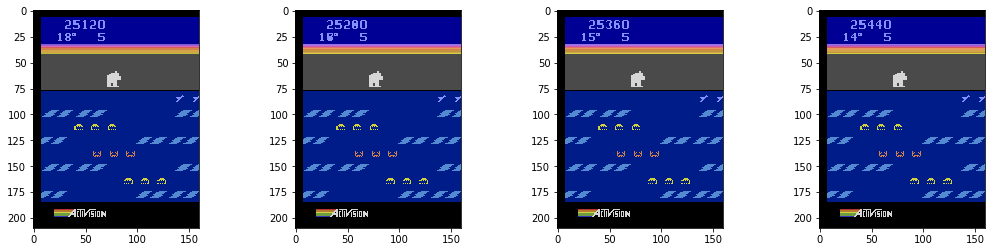

At index 2708, masks+pixels had value 9.740 => down + right + fire (16), pixels only had value 1.649 => down + right + fire (16)


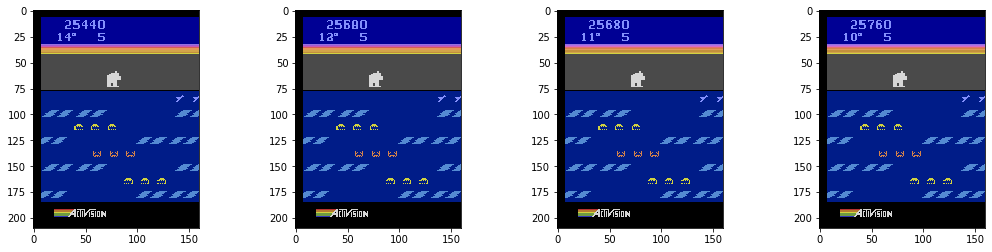

At index 5091, masks+pixels had value 7.873 => up + right + fire (14), pixels only had value 0.121 => right (3)


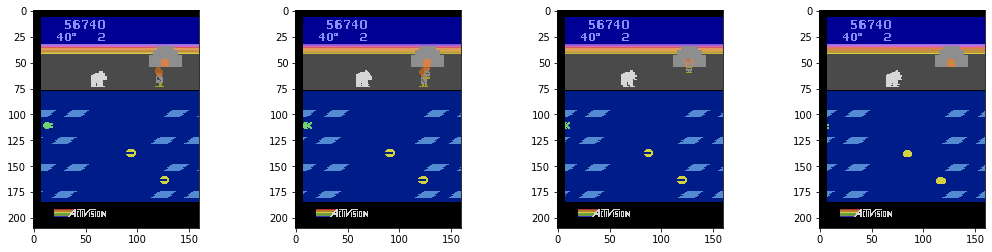

At index 5112, masks+pixels had value 9.897 => up + right + fire (14), pixels only had value 1.923 => up + right (6)


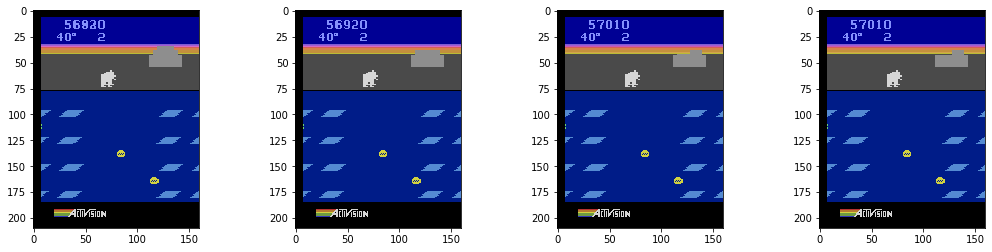

At index 5115, masks+pixels had value 9.969 => up + right + fire (14), pixels only had value 1.775 => down + left + fire (17)


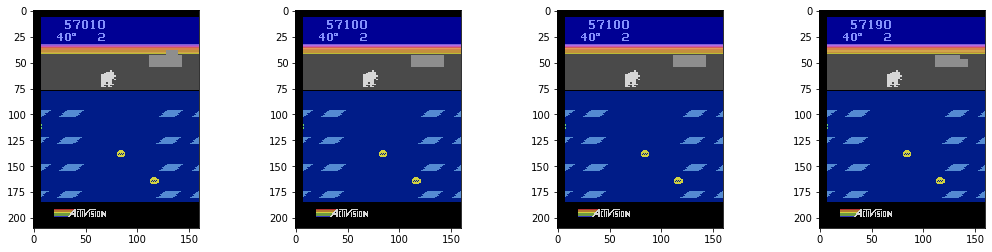

At index 5137, masks+pixels had value 9.988 => down + right + fire (16), pixels only had value 1.682 => down + left + fire (17)


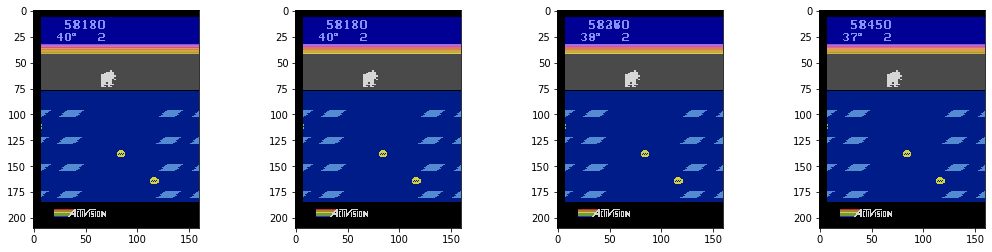

At index 5150, masks+pixels had value 9.932 => down + right + fire (16), pixels only had value 1.671 => down + left + fire (17)


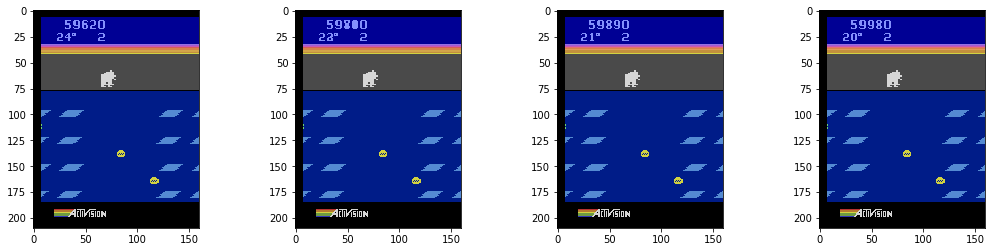

At index 5152, masks+pixels had value 9.934 => down + right + fire (16), pixels only had value 2.313 => down + left + fire (17)


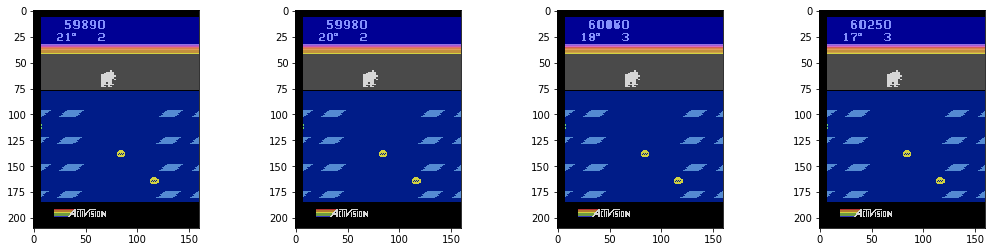

In [32]:
for index in sorted(np.nonzero(np.logical_and(normalized_diffs < 3.5, normalized_diffs > 3))[0]):
    mp_value = masks_and_pixels_state_value_array[index]
    mp_action = masks_and_pixels_action_array[index]
    baseline_value = baseline_state_value_array[index]
    baseline_action = baseline_action_array[index]
    print(f'At index {index}, masks+pixels had value {mp_value:.3f} => {ALE_ACTIONS[mp_action]} ({mp_action}), pixels only had value {baseline_value:.3f} => {ALE_ACTIONS[baseline_action]} ({baseline_action})')
    plot_entire_state(sample_full_color_observations, index)

At index 480, masks+pixels had value 2.426 => up + right + fire (14), pixels only had value 9.998 => up + right (6)


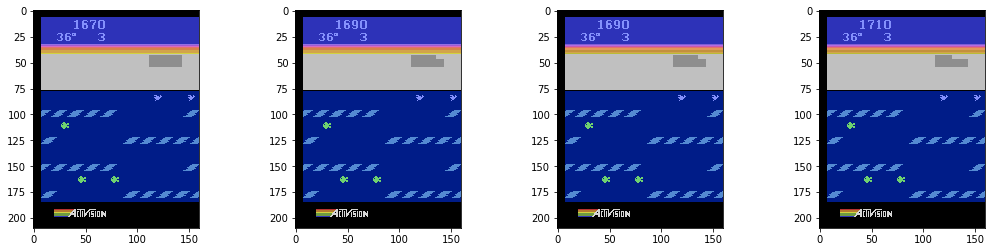

At index 782, masks+pixels had value 0.838 => down + fire (13), pixels only had value 7.885 => noop (0)


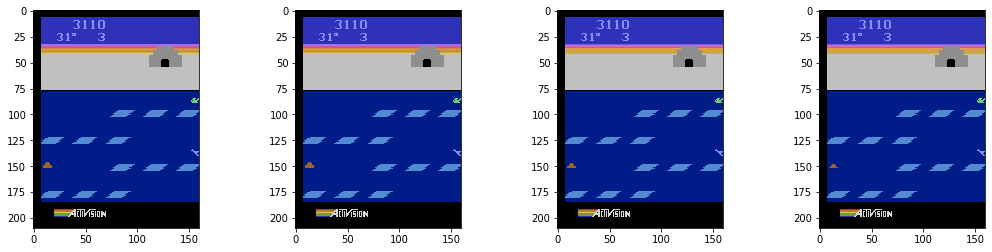

At index 783, masks+pixels had value 0.710 => down + fire (13), pixels only had value 7.903 => noop (0)


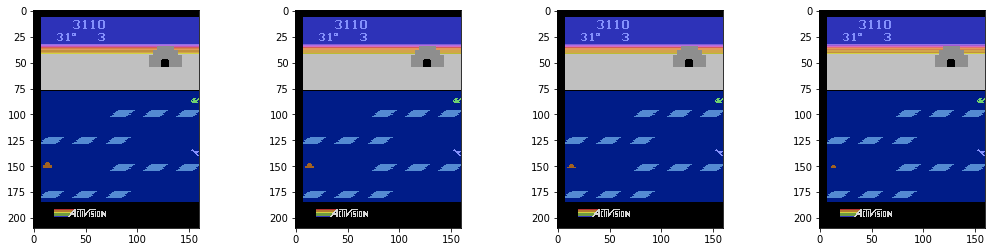

At index 784, masks+pixels had value 0.672 => fire (1), pixels only had value 8.086 => up + right (6)


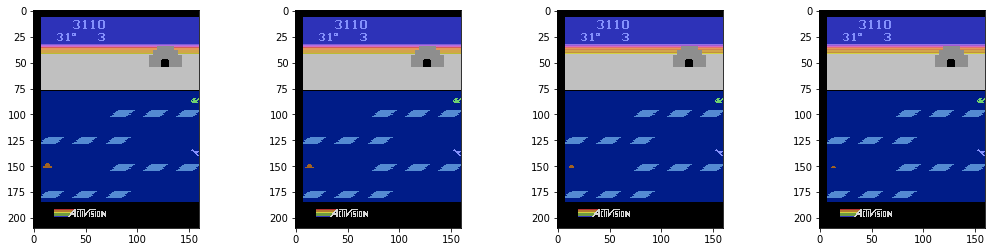

At index 785, masks+pixels had value 0.828 => down + fire (13), pixels only had value 8.161 => up + right (6)


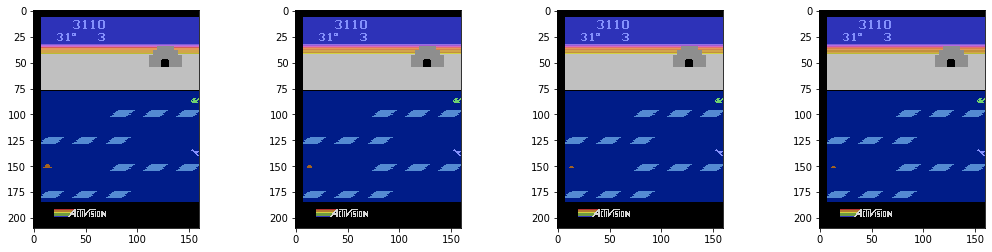

At index 786, masks+pixels had value 0.848 => down + fire (13), pixels only had value 7.747 => up + right (6)


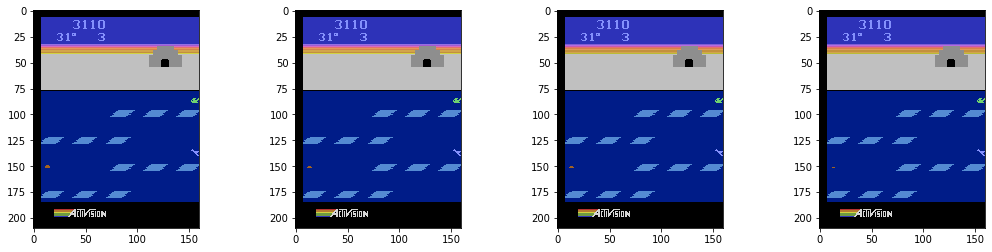

At index 787, masks+pixels had value 0.661 => down (5), pixels only had value 7.765 => down + right + fire (16)


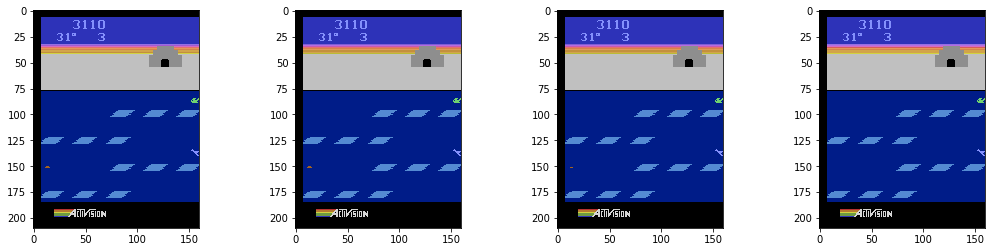

At index 788, masks+pixels had value 0.602 => down (5), pixels only had value 7.781 => down + right + fire (16)


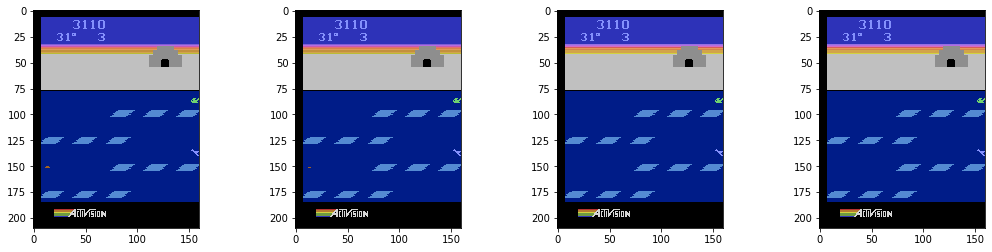

At index 789, masks+pixels had value 0.696 => down (5), pixels only had value 7.664 => down + right + fire (16)


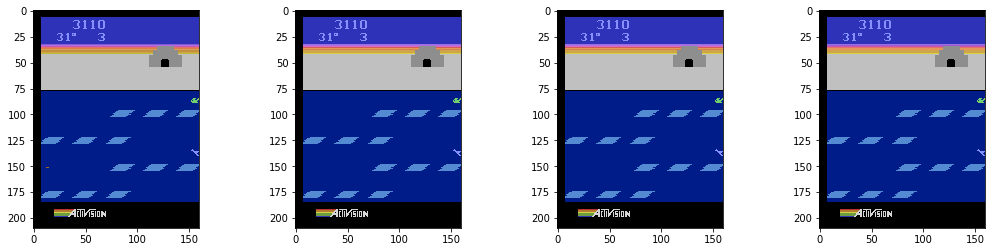

At index 791, masks+pixels had value 0.781 => down + fire (13), pixels only had value 8.181 => fire (1)


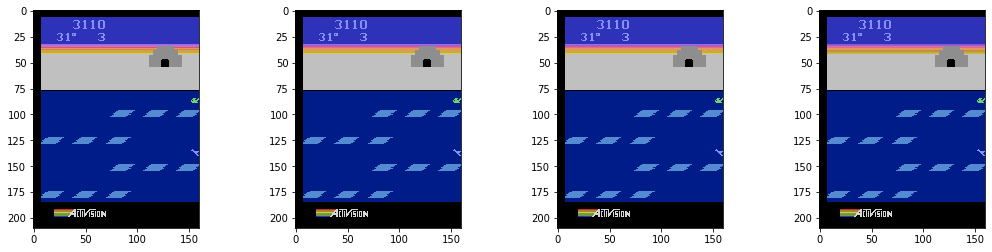

At index 792, masks+pixels had value 0.822 => down + fire (13), pixels only had value 8.099 => fire (1)


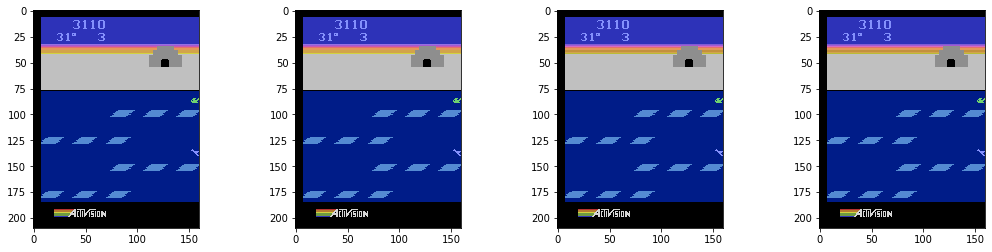

At index 793, masks+pixels had value 0.725 => down (5), pixels only had value 8.054 => down + right + fire (16)


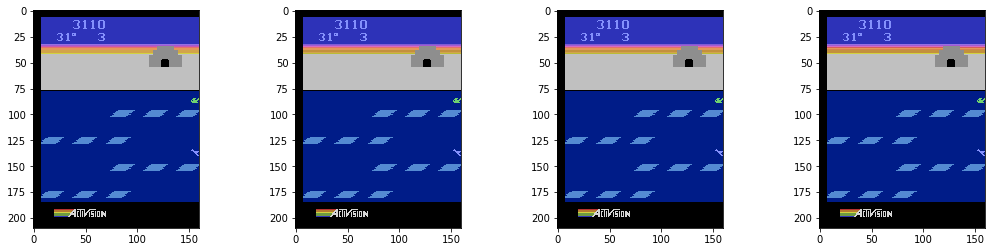

At index 794, masks+pixels had value 0.629 => down (5), pixels only had value 8.033 => up + left + fire (15)


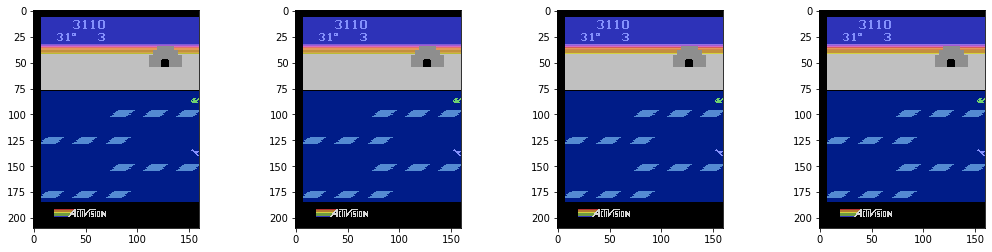

At index 795, masks+pixels had value 0.728 => down (5), pixels only had value 7.621 => up + left + fire (15)


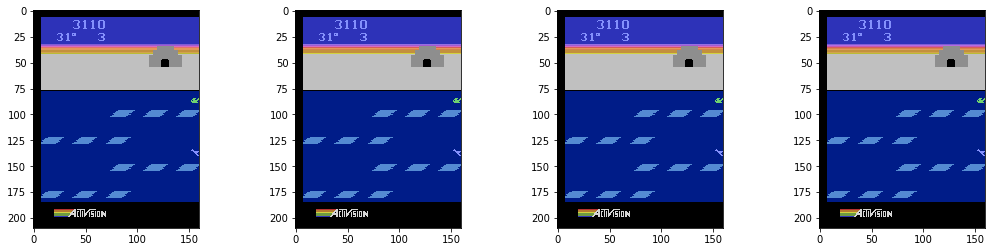

At index 796, masks+pixels had value 0.710 => down + fire (13), pixels only had value 7.618 => up + left + fire (15)


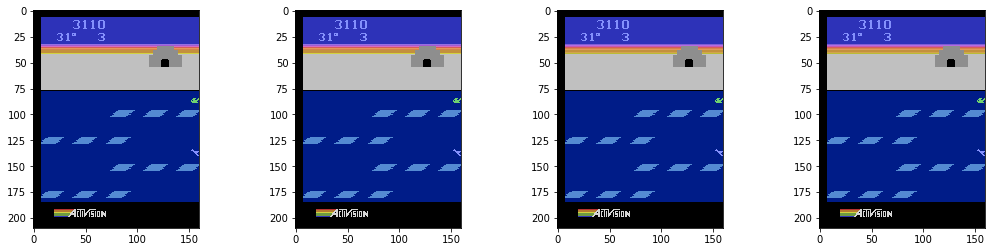

At index 799, masks+pixels had value 0.635 => down (5), pixels only had value 7.921 => noop (0)


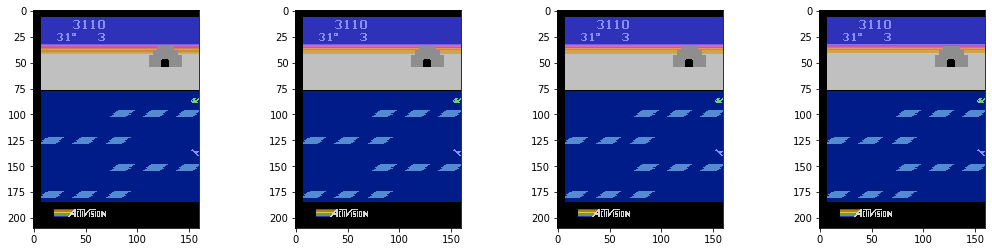

At index 800, masks+pixels had value 0.711 => down (5), pixels only had value 8.273 => noop (0)


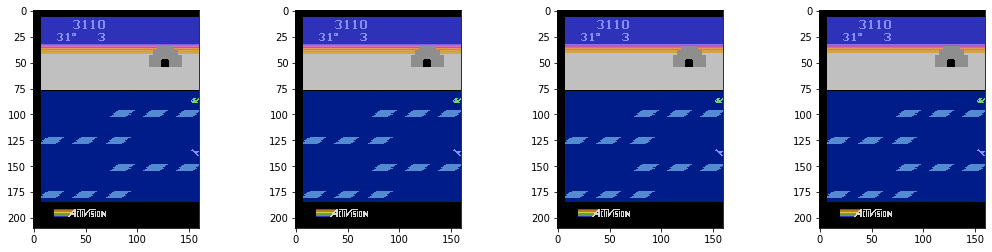

At index 801, masks+pixels had value 0.765 => down + fire (13), pixels only had value 8.151 => up + left + fire (15)


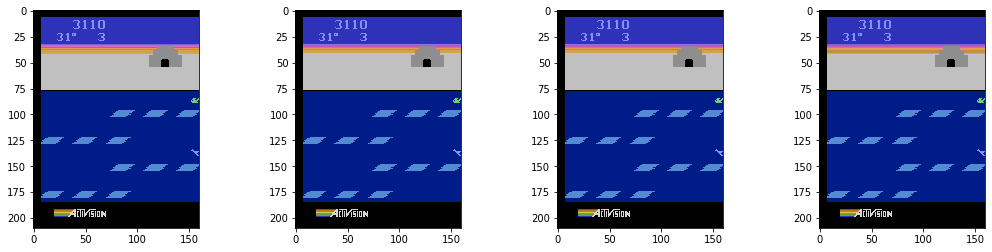

At index 802, masks+pixels had value 0.787 => down + fire (13), pixels only had value 7.911 => up + left + fire (15)


In [ ]:
for index in sorted(np.nonzero(np.logical_and(normalized_diffs > -3.5, normalized_diffs < -3))[0]):
    mp_value = masks_and_pixels_state_value_array[index]
    mp_action = masks_and_pixels_action_array[index]
    baseline_value = baseline_state_value_array[index]
    baseline_action = baseline_action_array[index]
    print(f'At index {index}, masks+pixels had value {mp_value:.3f} => {ALE_ACTIONS[mp_action]} ({mp_action}), pixels only had value {baseline_value:.3f} => {ALE_ACTIONS[baseline_action]} ({baseline_action})')
    plot_entire_state(sample_full_color_observations, index)